# Computing NLO Phase Shifts in Coordinate Space

We have seen that computing NLO phase shifts at large Lambda = 2/R values is numerically difficult – presumably because of the Fourier transform. We will try and bypass those issues by doing the calculation entirely in coordinate space.

The $t$-matrix amplitude is approximated as
$$
t = t^{(0)} + t^{(1)}
$$
We're going to consider the Born approximation for $t^{(1)}$,
$$
t^{(1)} \approx -\frac{2\mu}{k} \langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle
$$

(Is this the DWBA?)

We need $\phi^{(0)}$, and we need it properly/consistently **normalized**. Then we need to compute the integral. Finally, we'll (carefully) extract the phase shift via
$$
e^{2i\delta} = S = 1 - 2it
$$

Steps:

1. Compute $\phi^{(0)}$.
2. Compute $\delta^{(0)}$ (compare to previous results).
3. Normalize $\phi^{(0)}$. (???)
4. Compute $t^{(0)} = e^{i\delta^{(0)}}\sin\delta^{(0)}$
5. Compute the matrix element (integral), $\langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle$.
6. Compute $t=t^{(0)} + t^{(1)}$ and extract the NLO $\delta$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from finite_differences import second_order_deriv
from interaction import regulator
from counterterm import local_LO_counterterm
from constants import MU, BETA4, C4
from utility import log_mesh
from free_solutions import phase_shift, phase_shift_interp, phi_free

plt.style.use('science')
ratio = 4/3
h = 3

Read in RG flows (LO and NLO) and LO results.

In [2]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
rgf_nlo = np.loadtxt('rgflow_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')

deltas_lo = np.loadtxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt')
ks_lo = deltas_lo[:, 0]
deltas_lo = deltas_lo[:, 1:].T

At what energies/momenta are we going to compute the phase shifts?

In [3]:
# ks = np.hstack(
#     (np.logspace(np.log10(0.1/BETA4), np.log10(10/BETA4), 50),
#      np.linspace(10.1/BETA4, 100/BETA4, 50))
# )
ks = np.logspace(np.log10(1/BETA4), np.log10(np.sqrt(1000)/BETA4), 50)
energies = ks**2/(2*MU)

## 1. $\phi^{(0)}$

In [4]:
def wave_function(v_r, energy, r_endpts=np.array([1e-2, 10000])):
#     k0 = np.sqrt(2*MU* np.abs(v_r(0) - energy))
    k = np.sqrt(2*MU*energy)
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol

We'll work at a single $R$ value for now.

In [5]:
index = 30
R, c0, c2 = rgf_nlo[index]

def v4(r):
    if r == 0:
        return 0
    else:
        return -C4/r**4

pot = lambda r: regulator(r, R)*v4(r) + c0*local_LO_counterterm(r, R)

BETA4/R

38.78787878787879

In [6]:
phi0_solutions = [wave_function(pot, en) for en in tqdm(energies)]

100%|███████████████████████████████████████████| 50/50 [00:30<00:00,  1.61it/s]


## 2. $\delta^{(0)}$

In [7]:
def delta_interp(sol, k, r_match=600, max_rel_diff=1e-7, factor=1.01, dx=1e-6):
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > max_rel_diff:
        r = np.linspace(0.99*r_match, 1.01*r_match, 100)
        rho = k*r
        u, _ = sol(r)
        delta_1 = phase_shift_interp(u, rho, 0, k*r_match, dx=dx).real
        
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        r_match *= factor
    
    return delta_1

In [8]:
delta0s = np.array([delta_interp(sol, k) for (sol, k) in zip(phi0_solutions, ks)])

/Users/danielodell/XH-scattering/free_solutions.py:80: RuntimeWarning: divide by zero encountered in true_divide
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/Users/danielodell/XH-scattering/free_solutions.py:82: RuntimeWarning: invalid value encountered in multiply
  (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) /
/Users/danielodell/XH-scattering/free_solutions.py:83: RuntimeWarning: invalid value encountered in multiply
  (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))


In [9]:
ii = np.argmin(np.abs(R - rgf[:, 0]))
BETA4/rgf[ii, 0]

38.78787878787879

Do I get what I got before for $\delta^{(0)}$?

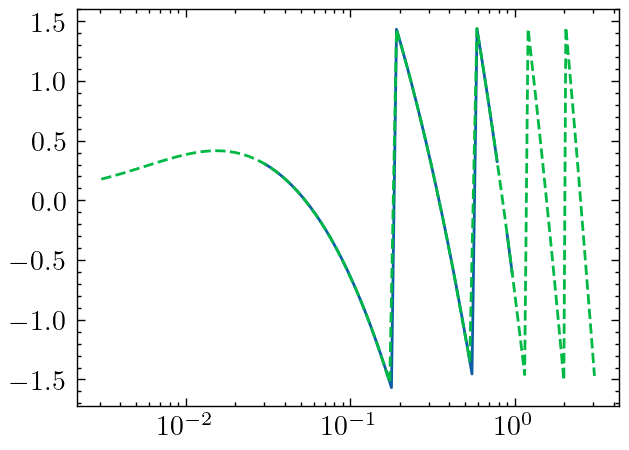

In [10]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(ks, delta0s)
ax.plot(ks_lo, deltas_lo[ii], linestyle='--')

ax.set_xscale('log');

In [11]:
def norm_factors(phi, k, delta0):
    r_max_amp = 1/k*(np.pi/2 + 8*np.pi - delta0)
    return np.abs(phi(r_max_amp)[0]) # / (np.sqrt(2/np.pi))

## 3. Normalize $\phi^{(0)}$

In [12]:
nfs = np.array([norm_factors(sol, k, d0) for (sol, k, d0) in zip(phi0_solutions, ks, delta0s)])

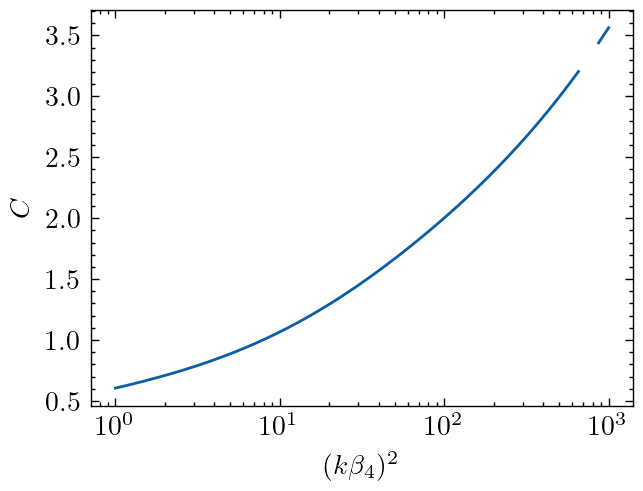

In [13]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, 1/nfs)

ax.set_ylabel(r'$C$')
ax.set_xlabel(r'$(k\beta_4)^2$');
ax.set_xscale('log');

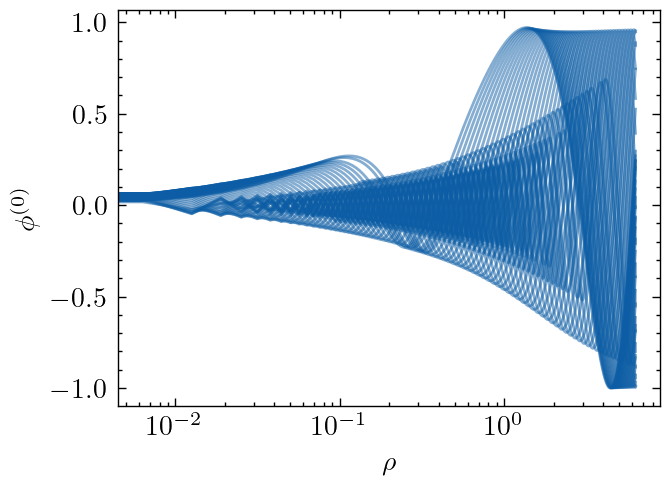

In [14]:
rho = np.linspace(0*np.pi, 2*np.pi, 1000)

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

stop = 100
for (k, nf, sol) in zip(ks[:stop], nfs[:stop], phi0_solutions[:stop]):
    r = rho / k
    ax.plot(rho, 1/nf*sol(r)[0], color='C0', alpha=0.5)
    
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\phi^{(0)}$');
ax.set_xscale('log');

1.8868424345884642


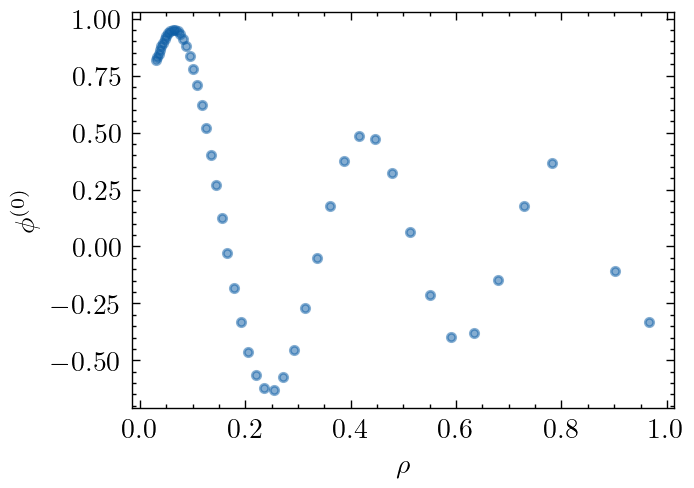

In [15]:
rho = np.linspace(0*np.pi, 2*np.pi, 1000)

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

stop = 100
for (k, nf, sol) in zip(ks[:stop], nfs[:stop], phi0_solutions[:stop]):
    r = rho / k
    ax.scatter(k, 1/nf*sol(r)[0][300], color='C0', alpha=0.5, marker='.')
    
print(rho[300])
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\phi^{(0)}$');
# ax.set_xscale('log');

In [16]:
r_int, _ = log_mesh(0, 2*R, 4000)

phi0_int = [phi(r_int)[0] / nf for (phi, nf, k) in zip(phi0_solutions, nfs, ks)]

## 4. $t^{(0)}$

In [17]:
t0s = np.array([np.exp(1j*d0) * np.sin(d0) for d0 in delta0s])

## 5. $\langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)}\rangle$

In [18]:
def integrand(phi0, energy):
    k = np.sqrt(2*MU*energy)
    v1 = c2 * energy * local_LO_counterterm(r_int, R)
    return interp1d(r_int, phi0 * v1 * phi0, kind='cubic')


def matrix_element(phi0, energy):
    k = np.sqrt(2*MU*energy)
    result = quad(integrand(phi0, energy), 1e-4, 2*R)
    return -2*MU/k * result[0]

In [19]:
integrands = [integrand(phi0, en) for (phi0, en) in zip(phi0_int, energies)]
mes = np.array([matrix_element(phi0, en) for (phi0, en) in zip(phi0_int, energies)])
mes_1 = np.array([me * np.exp(2j*d) for (me, d) in zip(mes, delta0s)])

/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_11523/1944490459.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(integrand(phi0, energy), 1e-4, 2*R)


(-0.05, 0.05)

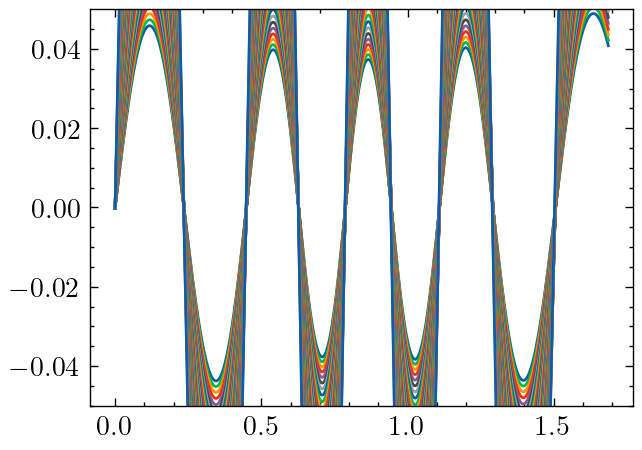

In [20]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for phi0 in phi0_int:
    ax.plot(r_int, phi0)

ax.set_ylim([-0.05, 0.05])

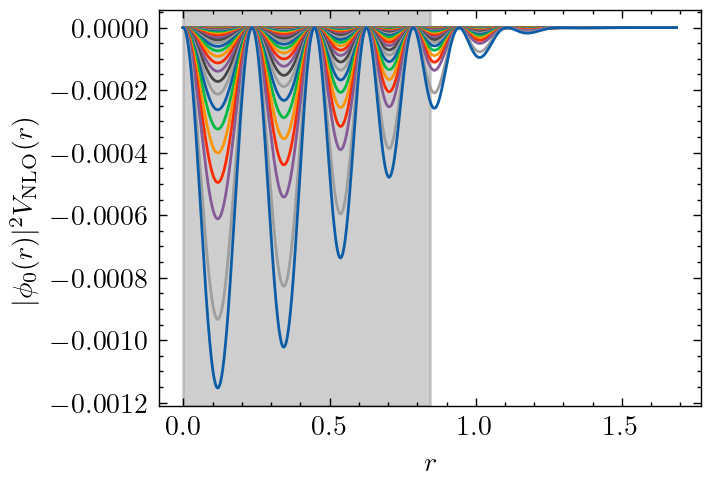

In [21]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for i in integrands:
    ax.plot(r_int, i(r_int))
    
ax.axvspan(0, R, alpha=0.5, color='C6')
ax.set_ylabel(r'$|\phi_0(r)|^2 V_{\rm NLO}(r)$')
ax.set_xlabel(r'$r$');

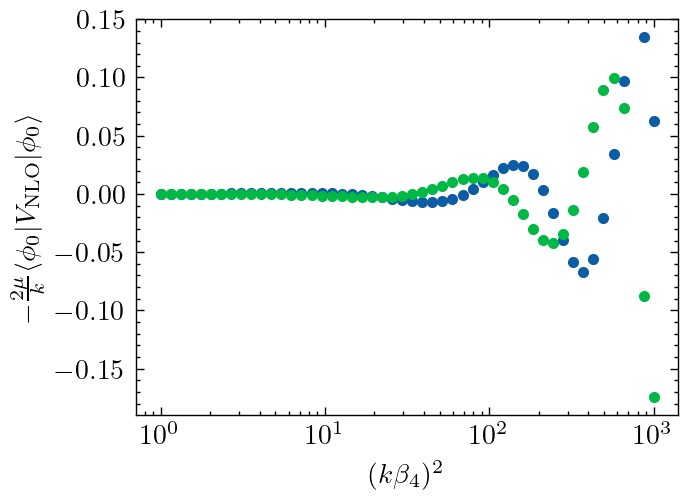

In [22]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.scatter((ks*BETA4)**2, mes_1.real, marker='.')
ax.scatter((ks*BETA4)**2, mes_1.imag, marker='.')

ax.set_ylabel(r'$-\frac{2\mu}{k}\langle \phi_0 | V_{\rm NLO} | \phi_0 \rangle$')
ax.set_xlabel(r'$(k\beta_4)^2$');
# ax.set_yscale('log');
ax.set_xscale('log');

## 6. $t\rightarrow\delta$

In [23]:
ts = t0s + mes_1
# deltas = np.arctan(ts)
deltas = np.arctan(ts / (1 + 1j*ts))
# s = 1 + 2j*ts
# deltas = 1/2j * np.log(s)

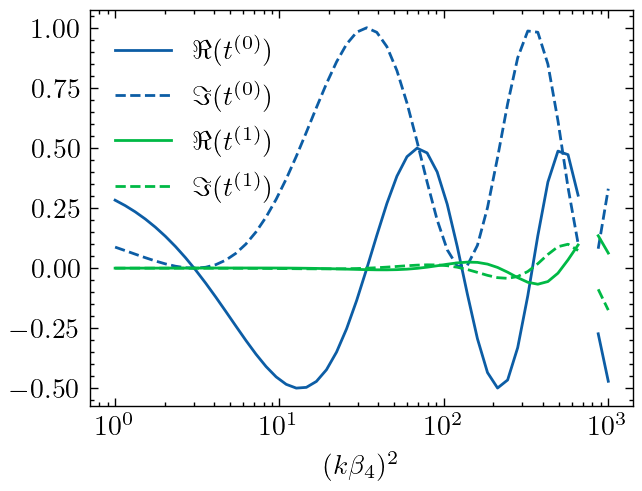

In [24]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, t0s.real, color='C0', label=r'$\Re(t^{(0)})$')
ax.plot((ks*BETA4)**2, t0s.imag, color='C0', linestyle='--', label=r'$\Im(t^{(0)})$')

ax.plot((ks*BETA4)**2, mes_1.real, color='C1', label=r'$\Re(t^{(1)})$')
ax.plot((ks*BETA4)**2, mes_1.imag, color='C1', linestyle='--', label=r'$\Im(t^{(1)})$')

ax.legend()
ax.set_xscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$');

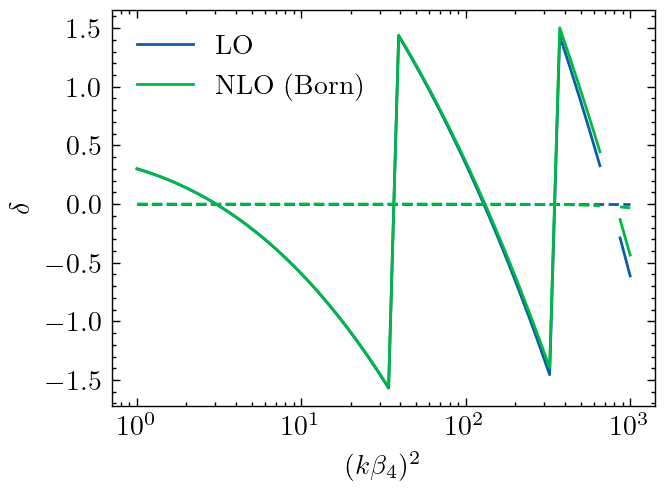

In [25]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, delta0s.real, color='C0', label='LO')
ax.plot((ks*BETA4)**2, delta0s.imag, color='C0', linestyle='--')

ax.plot((ks*BETA4)**2, deltas.real, color='C1', label='NLO (Born)')
ax.plot((ks*BETA4)**2, deltas.imag, color='C1', linestyle='--')

ax.legend()
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta$')
ax.set_xscale('log');

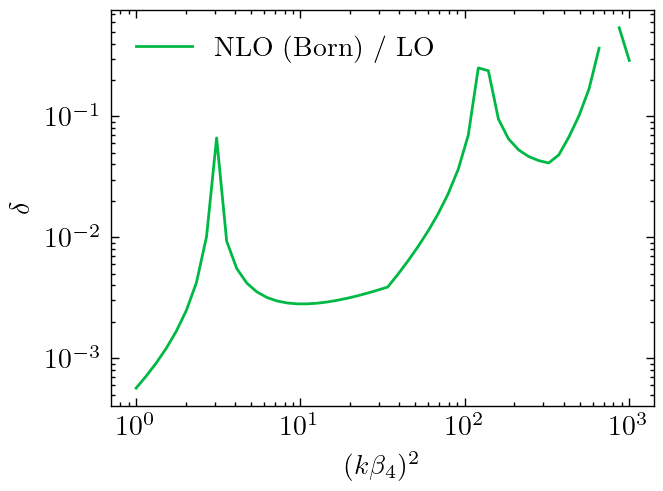

In [26]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

# ax.plot((ks*BETA4)**2, delta0s.real, color='C0', label='LO')
# ax.plot((ks*BETA4)**2, delta0s.imag, color='C0', linestyle='--')

ax.plot((ks*BETA4)**2, np.abs(deltas.real / delta0s.real - 1), color='C1', label='NLO (Born) / LO')
# ax.plot((ks*BETA4)**2, deltas.imag, color='C1', linestyle='--')

ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta$')
ax.set_xscale('log');

In [27]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

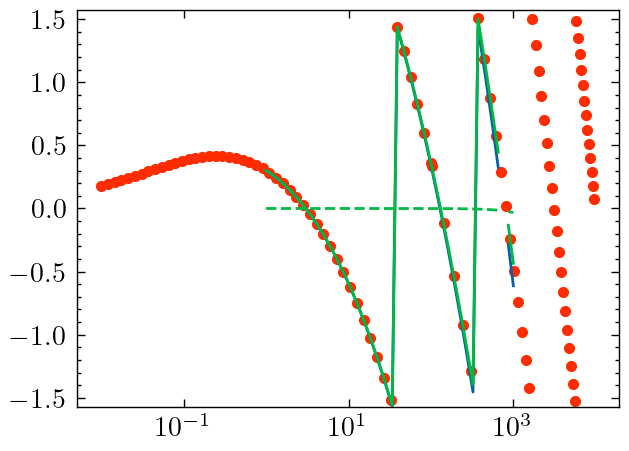

In [28]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')


ax.plot((ks*BETA4)**2, delta0s, color='C0')
ax.plot((ks*BETA4)**2, deltas.real, color='C1')
ax.plot((ks*BETA4)**2, deltas.imag, color='C1', linestyle='--')
ax.scatter((ks_mm*BETA4)**2, deltas_mm, color='C3', marker='.')

ax.set_ylim([-np.pi/2, np.pi/2])
# ax.set_xlim([0.1, 30])
ax.set_xscale('log');

In [29]:
# np.savetxt('phase_shifts_nlo_pert1_wide_dense_hp_n_14_true_coord_ir_corrected.txt',
#            np.vstack((ks, deltas)).T)

In [30]:
Delta = 5*np.pi

def find_minus_to_plus(x):
    n = x.size
    indices = []
    for i in range(n-1):
        if np.sign(x[i]) == -1 and  np.sign(x[i+1]) == 1:
            indices.append(i+1)
    return indices

def shift(x, add_pi=False):
    xp = x.copy()
    indices = find_minus_to_plus(xp)
    i = 0
    s = 0
    for j in indices:
#         print(i, j, s)
        xp[i:j] -= s*np.pi
        s += 1
        i = j
    xp[j:] -= s*np.pi
    return xp + (Delta if add_pi else 0)

In [31]:
mm = shift(deltas_mm, True)
lo = shift(delta0s, True)
nlo = shift(deltas, True)

In [32]:
f_mm = interp1d(ks_mm[:-1], mm[:-1], kind='cubic')

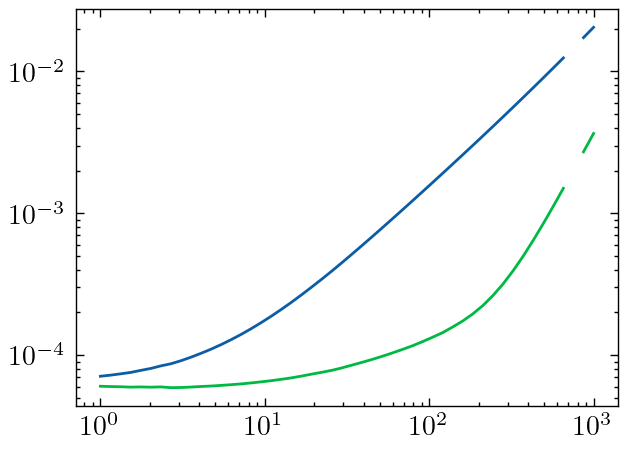

In [33]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, np.abs(lo/f_mm(ks) - 1))
ax.plot((ks*BETA4)**2, np.abs(nlo/f_mm(ks) - 1))

ax.set_xscale('log')
ax.set_yscale('log');

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


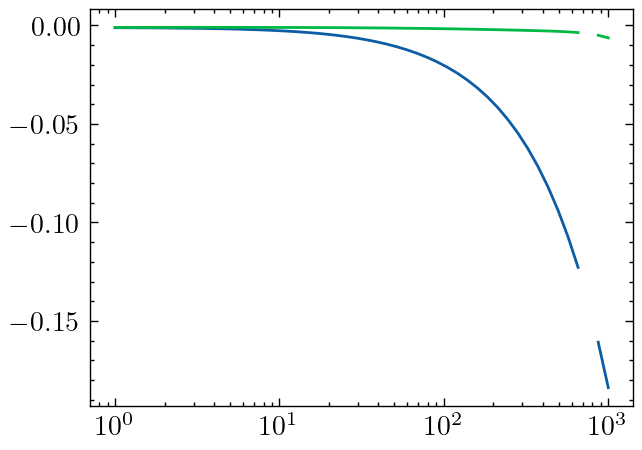

In [34]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, lo - f_mm(ks))
ax.plot((ks*BETA4)**2, nlo - f_mm(ks))

ax.set_xscale('log')
# ax.set_ylim([-0.5, 0.5])
# ax.set_xlim([1, 100])
# ax.set_yscale('log');